In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import amfe
from pyfeti import utils
from amfe.contact import jenkins, Nonlinear_force_assembler, Create_node2node_force_object
import time
import scipy.sparse as sparse
import scipy
import sparse as sp
from scipy.optimize import minimize, root
from contpy import optimize as copt, frequency
import numdifftools as nd

def timing(f):
    def wrap(*args):
        time1 = time.time()
        ret = f(*args)
        time2 = time.time()
        print('{:s} function took {:.3f} ms'.format(f.__name__, (time2-time1)*1000.0))

        return ret
    return wrap

Python was not able to load the fast fortran assembly routines.

Python was not able to load the fast fortran material routines.

Warning! Using python in global path


In [2]:
# geometric properties
dimension= 2
width= 5.0
heigh = 1.0
init_gap_x = width - 0.2*width
init_gap_y = -heigh - 0.01*heigh


#mesh properties
x_divisions,y_divisions= 51,21
#x_divisions,y_divisions= 21,6


#-------------------------------------------------------------------------------------------------------------------------
# Creating mesh for 2 bodies
d1= utils.DomainCreator(width=width, heigh=heigh, 
                         x_divisions=x_divisions, y_divisions=y_divisions, 
                         domain_id=1, start_x=0.0, start_y=0.0)

mesh_file_1 = 'domain_1.msh'
d1.save_gmsh_file(mesh_file_1)
m = amfe.Mesh()
m.import_msh(mesh_file_1)


m1 = m.translation(np.array([0., 0.]))
m2 = m.translation(np.array([init_gap_x,init_gap_y]))


<IPython.core.display.Javascript object>


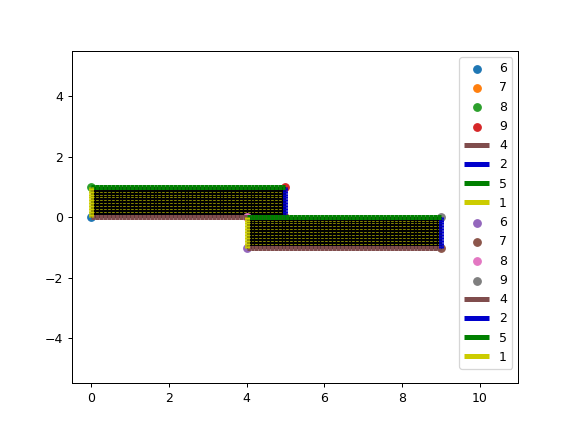

In [3]:

ax1 = amfe.plot2Dmesh(m1)
amfe.plot2Dmesh(m2,ax=ax1)
ax1.set_xlim([-0.5 ,2.2*width])
ax1.set_ylim([-1.1*width,1.1*width])
#ax1.legend('off')
plt.show()

In [4]:
# Defining contact pairs
m1.split_in_groups()
m2.split_in_groups()


tol_radius = 5.0E-1
contact_12_tag = 4
contact_21_tag = 5

# contact pair 12
d1 = m1.get_submesh('phys_group',contact_12_tag)
d2 = m2.get_submesh('phys_group',contact_21_tag)

contact12 = amfe.contact.Contact(d1,d2,tol_radius=tol_radius)
print('Number of contact pairs = %i' %len(contact12.contact_elem_dict))

It was not possible to find a slave node for master node 0. Minimum distance is 4.000012e+00
It was not possible to find a slave node for master node 1. Minimum distance is 3.900013e+00
It was not possible to find a slave node for master node 2. Minimum distance is 3.800013e+00
It was not possible to find a slave node for master node 3. Minimum distance is 3.700014e+00
It was not possible to find a slave node for master node 4. Minimum distance is 3.600014e+00
It was not possible to find a slave node for master node 5. Minimum distance is 3.500014e+00
It was not possible to find a slave node for master node 6. Minimum distance is 3.400015e+00
It was not possible to find a slave node for master node 7. Minimum distance is 3.300015e+00
It was not possible to find a slave node for master node 8. Minimum distance is 3.200016e+00
It was not possible to find a slave node for master node 9. Minimum distance is 3.100016e+00
It was not possible to find a slave node for master node 10. Minimum d

In [5]:
contact12.

In [ ]:
contact12.master_normal_dict

In [ ]:
rho = 7.85E-9 # ton/mm
E = 2.10E5 # MPa = N/mm2
my_material_template = amfe.KirchhoffMaterial(E=E, nu=0.3, rho=rho, plane_stress=False)

component_dict = {1:{'mesh' : m1, 
                     'domain_tag':3,
                     'external_force_tag':2,
                     'external_force_direction':1,
                     'force_value':1.0,
                     'Dirichlet_tag':1,
                     'material' : my_material_template},
                   2:{'mesh': m2, 
                      'domain_tag':3,
                      'external_force_tag':1,
                      'external_force_direction':0,
                      'force_value':0,
                       'Dirichlet_tag':2,
                       'material' : my_material_template}}


ro=1.0E7
N0=0.0E0
k= 1.0E0
mu= 0.0
contact_dict = {'12' : {'contact' : contact12, 
                        'contact_pair_id' : (1,2),
                        'elem_type' : 'jenkins' , 
                        'elem_properties' : {'ro':ro,'N0':N0,'k':k, 'mu':mu}}}

In [ ]:
from pyfeti.src.utils import DomainCreator, dict2dfmap, create_selection_operator, DofManager
def components2list(component_dict,dimension=3):
    K_list = []
    M_list = []
    f_list = []
    for domain_id, param_dict in component_dict.items():

        globals().update(param_dict)
        #print(param_dict)
        #print(locals())
        m = mesh 
        my_comp = amfe.MechanicalSystem()
        my_comp.set_mesh_obj(m)
        my_comp.set_domain(domain_tag,material)

        if dimension==3:

            if external_force_direction == 0:
                direction = np.array([1.,0.,0.])
            elif external_force_direction == 1:
                direction = np.array([0.,1.,0.])
            else:
                direction = np.array([0.,0.,1.])
                
        elif dimension==2:
            if external_force_direction == 0:
                direction = np.array([1.,0.])
            elif external_force_direction == 1:
                direction = np.array([0.,1.])
            

        my_comp.apply_neumann_boundaries(external_force_tag,force_value,direction)
        print('Number of nodes is equal to %i' %my_comp.mesh_class.no_of_nodes)

        K, f_ = my_comp.assembly_class.assemble_k_and_f()
        _, fext = my_comp.assembly_class.assemble_k_and_f_neumann()
        M = my_comp.assembly_class.assemble_m()


        try:
            connectivity = []
            for _,item in m.el_df.iloc[:, m.node_idx:].iterrows():
                connectivity.append(list(item.dropna().astype(dtype='int64')))
            m.el_df['connectivity'] = connectivity
        except:
            pass

        id_matrix = my_comp.assembly_class.id_matrix
        id_map_df = dict2dfmap(id_matrix)
        s = create_selection_operator(id_map_df,m.el_df)

        from pyfeti.src.linalg import Matrix
        K1 = Matrix(K,key_dict=s.selection_dict)
        M1 = Matrix(M,key_dict=s.selection_dict)


        # applying Dirichlet B.C.
        K1.eliminate_by_identity(Dirichlet_tag,1.0E15)
        M1.eliminate_by_identity(Dirichlet_tag,0.0)

        K_list.append(K1.data)
        M_list.append(M1.data)
        f_list.append(fext)
        
    return K_list, M_list, f_list
    
def list2global(K_list, M_list, f_list, alpha=1.0E-3, beta=1.0E-7):
   
    K_global = sparse.block_diag(K_list)
    M_global = sparse.block_diag(M_list)
    
    C_global = alpha*K_global + beta*M_global
    f_global = np.concatenate(f_list)
    f_global/=np.linalg.norm(f_global)

    return K_global.tocsc(),M_global.tocsc(),C_global.tocsc(),f_global


def create_map_local_domain_dofs_dimension(component_dict,dimension=3):
    map_local_domain_dofs_dimension = {}
    for domain_id, param_dict in component_dict.items():
        m_ = param_dict['mesh']
        map_local_domain_dofs_dimension[domain_id] = m_.no_of_nodes*dimension
    return map_local_domain_dofs_dimension

class SplitOperator():
    def __init__(self,map_local_domain_dofs_dimension):
        self.map_local_domain_dofs_dimension = map_local_domain_dofs_dimension
        
    def LinearOperator(self,u):
        u_list = []
        idx = 0
        for key, item in self.map_local_domain_dofs_dimension.items():
            try:
                u_list.append(u[idx:idx+item])
            except:
                u_list.append(u[idx:])
            idx = item
        return u_list
        
class Nonlinear_Force():
    def __init__(self,Fnl_obj_list):
        self.Fnl_obj_list = Fnl_obj_list
        
    def compute_force(self,u,X0=None):
        Fnl_obj_list = self.Fnl_obj_list
        for fnl_obj_item in Fnl_obj_list:
            try:
                output += fnl_obj_item.compute(u,X0)
            except:
                output = fnl_obj_item.compute(u,X0)

        return output
        
    def compute_jacobian(self,u,X0=None):
        Fnl_obj_list = self.Fnl_obj_list
        for fnl_obj_item in Fnl_obj_list:
            try:
                output += fnl_obj_item.Jacobian(u,X0)
            except:
                output = fnl_obj_item.Jacobian(u,X0)

        return output
    
    
def force_in_time(fext,time_points,omega):
    
    f_list = []
    for i in range(time_points):
        a = rate*np.sin(2.0*np.pi*i/time_points)
        f1 = a*fext
        f_list.append(f1)

    return np.array(f_list).T

In [ ]:
K_list, M_list, f_list =components2list(component_dict,dimension=2)

K_global,M_global,C_global,f_global =  list2global(K_list, M_list, f_list,alpha = 1.0E-2, beta = 1.0E-4)

In [ ]:
# solving Eigenvalue problem for problem change of basis
K_global_inv = sparse.linalg.splu(K_global)
D = sparse.linalg.LinearOperator(shape=K_global.shape, matvec = lambda x : K_global_inv.solve(M_global.dot(x)))

#modes = K_global.shape[0] - 2
modes = 20
val, Phi = sparse.linalg.eigs(D,k=modes)
Phi = Phi.real
normalizeit = True
if normalizeit:
    for i in range(modes):
        vi = Phi[:,i]
        Phi[:,i] = vi/np.linalg.norm(vi)  

In [ ]:
K_global.shape

In [ ]:
map_local_domain_dofs_dimension = create_map_local_domain_dofs_dimension(component_dict,dimension=2)

In [ ]:
SO = SplitOperator(map_local_domain_dofs_dimension)

In [ ]:
from matplotlib import animation, rc
u_list = SO.LinearOperator(Phi[:,1])
fig, ax2 = plt.subplots(1,1, figsize=(8,8))

mesh_list = [m1,m2]
factor=6.0
def update(factor=6.0):
    i=0
    ax2.clear()
    for key, mesh_dict_ in component_dict.items():
        me = mesh_dict_['mesh']
        #me = mesh_list[i]
        p1, _ = amfe.plotDeformQuadMesh(me.connectivity,me.nodes,u_list[i],factor=factor,ax=ax2,color_id=1)
        i+=1

    ax2.set_xlim([0,2.2*width])
    ax2.set_ylim([-1.1*width,1.1*width])
    ax2.legend('off')
    
    
#update(10)
frame_list = list(map(lambda x : 2.0*np.sin(2.0*np.pi*x/100),range(100)))
anim = animation.FuncAnimation(fig, update,
                               frames=frame_list, interval=20)
plt.show()

In [ ]:
Fnl_obj_list = []
for contact_key,contact_item in contact_dict.items():
    bodies_contact_id = contact_item['contact_pair_id']
    contact_12 = contact_item['contact']
    elem_type = contact_item['elem_type']
    elem_properties = contact_item['elem_properties']
    create_obj_1 = Create_node2node_force_object(contact12,bodies_contact_id,elem_type,elem_properties,dimension,map_local_domain_dofs_dimension)
    Fnl_obj_list.append(create_obj_1.assemble_nonlinear_force())
    

In [ ]:
from contpy import optimize as copt, frequency, operators

nH = 2
omega = 1.0
time_points = nH*25
rate = 1.0E2

ndofs = K_global.shape[0]
Q = frequency.assemble_hbm_operator(ndofs,number_of_harm=nH ,n_points=time_points) # bases of truncaded Fourier
nonlinear_force_obj = Nonlinear_Force(Fnl_obj_list)
AFT  = operators.Nonlinear_Force_AFT(Q,nonlinear_force_obj)
Z = lambda w : frequency.create_Z_matrix(K_global,C_global,M_global,f0= w/(2.0*np.pi),nH=nH, static=False)
Zw = Z(omega)
Zw_real = copt.complex_matrix_to_real_block(Zw)
force_global_in_time = force_in_time(f_global,time_points,omega)
force_global_ = Q.H.dot(force_global_in_time)

In [ ]:
def Residual_and_Jac_in_real_block(u_real):
    u_ = copt.real_array_to_complex(u_real)
    fnl_complex_eval, Jnl_eval_1, Jnl_eval_conj_1 = AFT.compute_force_and_jac(u_)
    J_block_real = copt.complex_matrix_to_real_block(Jnl_eval_1, Jnl_eval_conj_1)
    J = Zw_real - J_block_real
    R = Zw.dot(u_) - force_global_ - fnl_complex_eval
    R_real = copt.complex_array_to_real(R)
    return R_real, J
    
    

In [ ]:
Zw_inv = sparse.linalg.splu(Zw)
u__initial = Zw_inv.solve(force_global_)
u__inital_real = copt.complex_array_to_real(u__initial)
u__inital_real = 0.0*u__inital_real

In [ ]:
class LM_Krylov(copt.LinearSolver):
    def __init__(self,x0,tol=1.0E-6,maxiter=50,verbose=False):
        self.tol = tol
        self.maxiter = maxiter
        self.verbose = verbose
        self.x0 = x0
        self._counter = 0
        self.max_reuse_precond = 10
        self.M = None
        self.info = 0
        super().__init__(**self.__dict__)
        
    def solve(self,A,b):
        
        if self._counter ==0:
            if self.verbose:
                print('Computing exact preconditioner')
            LU = sparse.linalg.splu(A)
            self.M = sparse.linalg.LinearOperator(shape=A.shape,matvec = lambda x : LU.solve(x))
            self._counter +=1
        elif self._counter==self.max_reuse_precond:
            self._counter = 0
        else:
            self._counter +=1
            
        x, self.info = sparse.linalg.gmres(A, b, x0=self.x0, tol=self.tol,maxiter=self.maxiter,M=self.M,  restart=self.max_reuse_precond)
        
        if self.verbose:
            print('GMRes info - %i' %self.info)
            
        if self.info!=0:
            self._counter = 0
            x = self.solve(A,b)
            
        return x
        
    def update(self,xn):
        if self.info==0:
            self.x0 = xn
        #self.maxiter += 2
        
   

class LM_CG_Krylov(copt.LinearSolver):
    def __init__(self,x0,tol=1.0E-6,maxiter=50,verbose=False):
        self.tol = tol
        self.maxiter = maxiter
        self.verbose = verbose
        self.x0 = x0
        self._counter = 0
        self.max_reuse_precond = 10
        self.M = None
        self.info = 0
        super().__init__(**self.__dict__)
        
    def solve(self,A,b):
        
        if self._counter ==0:
            if self.verbose:
                print('Computing exact preconditioner')
            LU = sparse.linalg.splu(A)
            self.M = sparse.linalg.LinearOperator(shape=A.shape,matvec = lambda x : LU.solve(x))
            self._counter +=1
        elif self._counter==self.max_reuse_precond:
            self._counter = 0
        else:
            self._counter +=1
            
        x, self.info = sparse.linalg.cg(A, b, x0=self.x0, tol=self.tol,maxiter=self.maxiter,M=self.M)
        
        if self.verbose:
            print('GMRes info - %i' %self.info)
            
        if self.info!=0:
            self._counter = 0
            x = self.solve(A,b)
            
        return x
        
    def update(self,xn):
        if self.info==0:
            self.x0 = xn
        #self.maxiter += 2
        

In [ ]:
sol2 = copt.LevenbergMarquardt(Residual_and_Jac_in_real_block,0.0*u__inital_real,method=None,jac=True,maxiter=200)
u_sol =   copt.real_array_to_complex(sol2.x)
u_sol_time = Q.dot(u_sol)

In [ ]:
ls_obj = LM_Krylov(u__inital_real,tol=1.0E-6,maxiter=50,verbose=True)
sol2 = copt.LevenbergMarquardt(Residual_and_Jac_in_real_block,u__inital_real,method=None,jac=True,maxiter=200, linear_solver=ls_obj)
u_sol =   copt.real_array_to_complex(sol2.x)
u_sol_time = Q.dot(u_sol)

In [ ]:
ls_cg_obj = LM_CG_Krylov(u__inital_real,tol=1.0E-6,maxiter=50,verbose=True)
sol2 = copt.LevenbergMarquardt(Residual_and_Jac_in_real_block,u__inital_real,method=None,jac=True,maxiter=200, linear_solver=ls_cg_obj)
u_sol =   copt.real_array_to_complex(sol2.x)
u_sol_time = Q.dot(u_sol)

In [ ]:
from matplotlib import animation, rc
u_list = SO.LinearOperator(u_sol_time)
fig2, ax2 = plt.subplots(1,1)

mesh_list = [m1,m2]
factor=6.0
def update_HBM(j,factor=6.0):
    i=0
    ax2.clear()
    for key, mesh_dict_ in component_dict.items():
        me = mesh_dict_['mesh']
        #me = mesh_list[i]
        p1, _ = amfe.plotDeformQuadMesh(me.connectivity,me.nodes,u_list[i].T[j],factor=factor,ax=ax2,color_id=2)
        i+=1

    ax2.set_xlim([0,2.2*width])
    ax2.set_ylim([-1.1*width,1.1*width])
    ax2.legend('off')
    
    
#update(10)
anim = animation.FuncAnimation(fig2, update_HBM,
                               frames=range(time_points), interval=1)

In [ ]:
Phi.shape

In [ ]:
Zw

In [ ]:
val

In [ ]:
V_ = Phi[:,0:2]
#[V_]*nH
V= sparse.block_diag(([V_]*nH))

Zw_mode = V.T@Zw@V
Zw_mode_real = copt.complex_matrix_to_real_block(Zw_mode)
def Residual_and_Jac_mode(q_real):
    q_complex = copt.real_array_to_complex(q_real)
    u_ = V.dot(q_complex)
    fnl_complex_eval, Jnl_eval_1, Jnl_eval_conj_1 = AFT.compute_force_and_jac(u_)
    J_block_real = copt.complex_matrix_to_real_block(V.T@Jnl_eval_1@V, V.T@Jnl_eval_conj_1@V)
    J = Zw_mode_real  - J_block_real
    R = Zw.dot(u_) - force_global_ - fnl_complex_eval
    VTR = V.T.dot(R)
    R_real = copt.complex_array_to_real(VTR)
    return R_real, J

In [ ]:
Zw_mode.A

In [ ]:
q_complex_1 = V.T.dot(u_sol)
#q_complex_1 = np.linalg.solve(Zw_mode,V.T@force_global_)
#q_complex = V.T.dot(u__initial)
q_real_init_1 = copt.complex_array_to_real(q_complex_1 )
#q_real_init_2 = copt.complex_array_to_real(q_complex_2 )
sol2_q = copt.LevenbergMarquardt(Residual_and_Jac_mode,q_real_init_1,method=None,jac=True,maxiter=200,tol=1.E-8)

#u = Vq
q_sol_complex = copt.real_array_to_complex(sol2_q.x)
u_sol_mode = V.dot(q_sol_complex)
u_sol_time_ = Q.dot(u_sol_mode)

In [ ]:
q_sol_complex

In [ ]:
from matplotlib import animation, rc
u_list_ = SO.LinearOperator(u_sol_time_)
fig3, ax3 = plt.subplots(1,1)

mesh_list = [m1,m2]
factor=6.0
def update_HBM_modes(j,factor=6.0):
    i=0
    ax3.clear()
    for key, mesh_dict_ in component_dict.items():
        me = mesh_dict_['mesh']
        #me = mesh_list[i]
        p1, _ = amfe.plotDeformQuadMesh(me.connectivity,me.nodes,u_list_[i].T[j],factor=factor,ax=ax3,color_id=3)
        i+=1

    ax3.set_xlim([0,2.2*width])
    ax3.set_ylim([-1.1*width,1.1*width])
    ax3.legend('off')
    
    
#update(10)
anim = animation.FuncAnimation(fig3, update_HBM_modes,frames=range(time_points), interval=20)

In [ ]:
fig4, (ax41, ax42) = plt.subplots(1,2, figsize=(6,6))
ax41.plot(u_sol.real,u_sol_mode.real,'o')
ax42.plot(u_sol.imag,u_sol_mode.imag,'*')
plt.show()

In [ ]:
u_sol_mode_real = copt.complex_array_to_real(0.0*u_sol_mode)
ls_cg_obj = LM_CG_Krylov(u_sol_mode_real,tol=1.0E-6, verbose=True)

sol2 = copt.LevenbergMarquardt(Residual_and_Jac_in_real_block, u_sol_mode_real,method=None,jac=True,maxiter=200, linear_solver=ls_cg_obj)
u_sol =   copt.real_array_to_complex(sol2.x)
u_sol_time = Q.dot(u_sol)

In [ ]:
u_sol_mode_real = copt.complex_array_to_real(u_sol_mode)
ls_cg_obj = LM_CG_Krylov(u_sol_mode_real,tol=1.0E-6, verbose=True)

sol2 = copt.LevenbergMarquardt(Residual_and_Jac_in_real_block, u_sol_mode_real,method=None,jac=True,maxiter=200, linear_solver=ls_cg_obj)
u_sol =   copt.real_array_to_complex(sol2.x)
u_sol_time = Q.dot(u_sol)

In [ ]:
u_sol_mode_real = copt.complex_array_to_real(u_sol_mode)
ls_obj_ = LM_Krylov(u_sol_mode_real,tol=1.0E-6, verbose=True)

sol2 = copt.LevenbergMarquardt(Residual_and_Jac_in_real_block, u_sol_mode_real,method=None,jac=True,maxiter=200,verbose=True,linear_solver=ls_obj_)
u_sol =   copt.real_array_to_complex(sol2.x)
u_sol_time = Q.dot(u_sol)

In [ ]:
u_sol_mode_real = copt.complex_array_to_real(u_sol_mode)
ls_obj_ = LM_Krylov(u_sol_mode_real,tol=1.0E-6, verbose=True)

sol2 = copt.Newton(Residual_and_Jac_in_real_block, u_sol_mode_real,method=None,jac=True,maxiter=200,verbose=True,linear_solver=ls_obj_)
u_sol =   copt.real_array_to_complex(sol2.x)
u_sol_time = Q.dot(u_sol)

In [ ]:
Zw.shape